<h1>나의 첫 번째 캐글 경진대회, 무작정 따라해보기<h1>

준비물

필요한 라이브러리 설치 확인 및 폴더 생성

$ conda list | grep xgboost

$ conda list | grep lightgbm

$ conda list | grep missingno

$ pip list | grep scikit-learn

mkdir -p ~/aiffel/EXPLORATION/06/kaggle_kakr_housing

실습 데이터 다운로드

$ mkdir -p ~/aiffel/EXPLORATION/06/kaggle_kakr_housing/data

$ ln -s ~/data/data/*.csv ~/aiffel/EXPLORATION/06/kaggle_kakr_housing/data

$ ls ~/aiffel/EXPLORATION/06/kaggle_kakr_housing/data  # 디렉토리 내 파일 확인

Baseline 셋팅하기

필요한 라이브러리 설치하기

$ conda install -c conda-forge xgboost=1.3.3

$ conda install -c conda-forge lightgbm=3.1.1 

$ conda install -c conda-forge missingno=0.4.2

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

 필요한 라이브러리 import 하기

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


데이터 경로 지정하기

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/06/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/EXPLORATION/06/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/EXPLORATION/06/kaggle_kakr_housing/data/test.csv


데이터 불러오기

In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


학습 데이터에서 라벨 제거하기

In [5]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


학습 데이터와 테스트 데이터 합치기

In [6]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


간단한 전처리

각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.

먼저 데이터에 결측치가 있는지를 확인하겠습니다.

missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

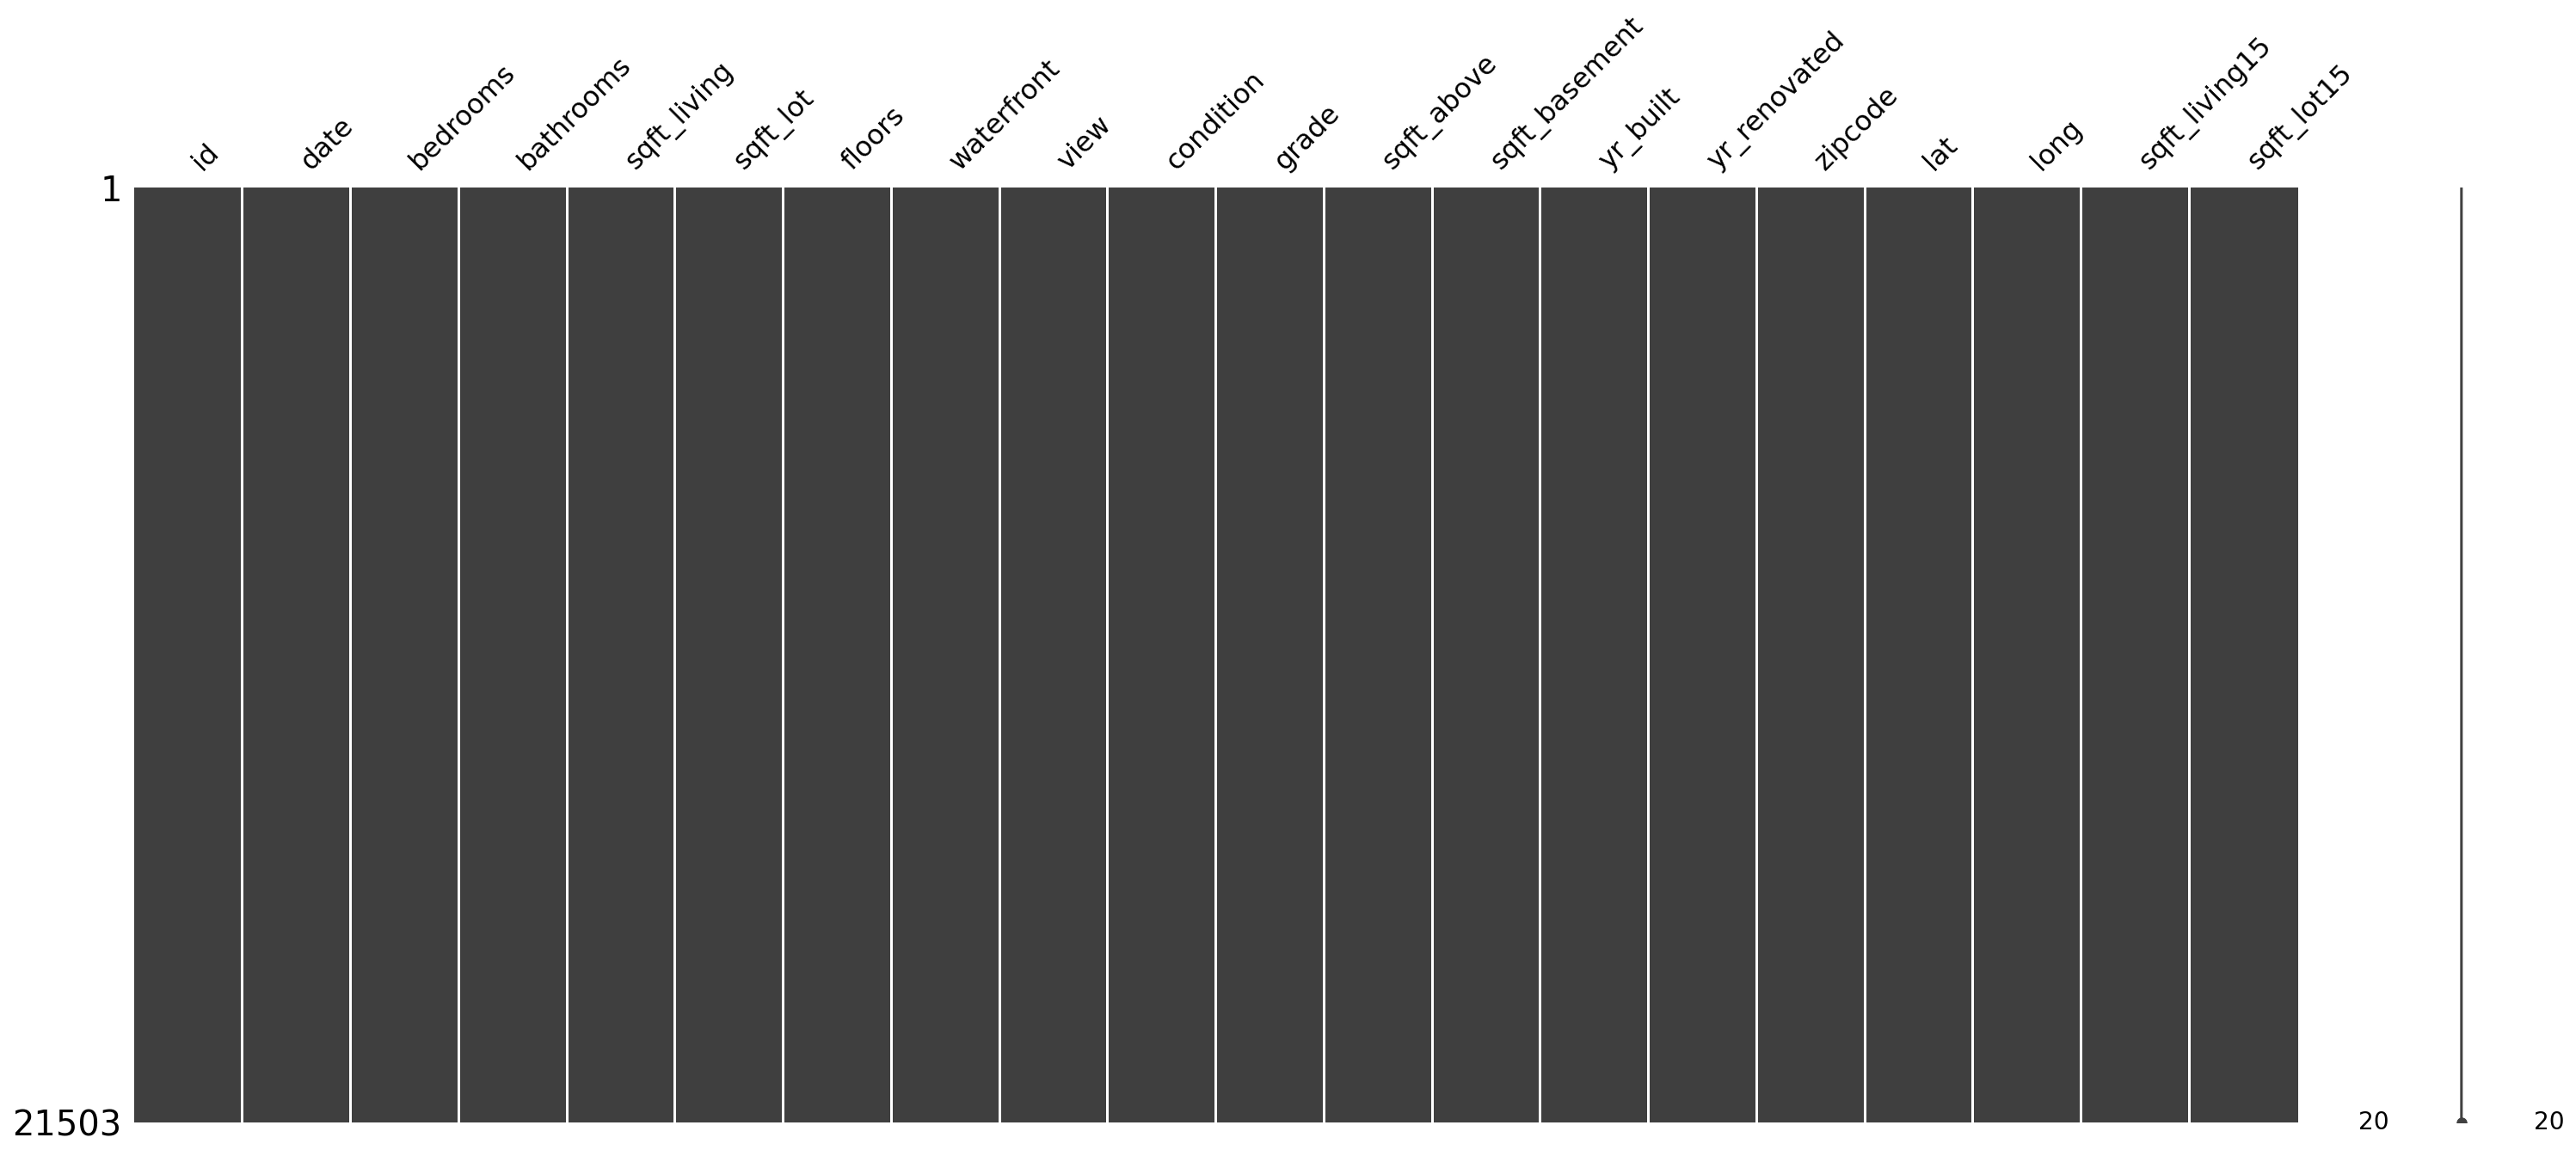

In [8]:
msno.matrix(data)

In [9]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


id, date 변수 정리

In [10]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date 컬럼은 apply 함수로 필요한 부분만 잘라줍니다.

In [11]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


각 변수들의 분포 확인

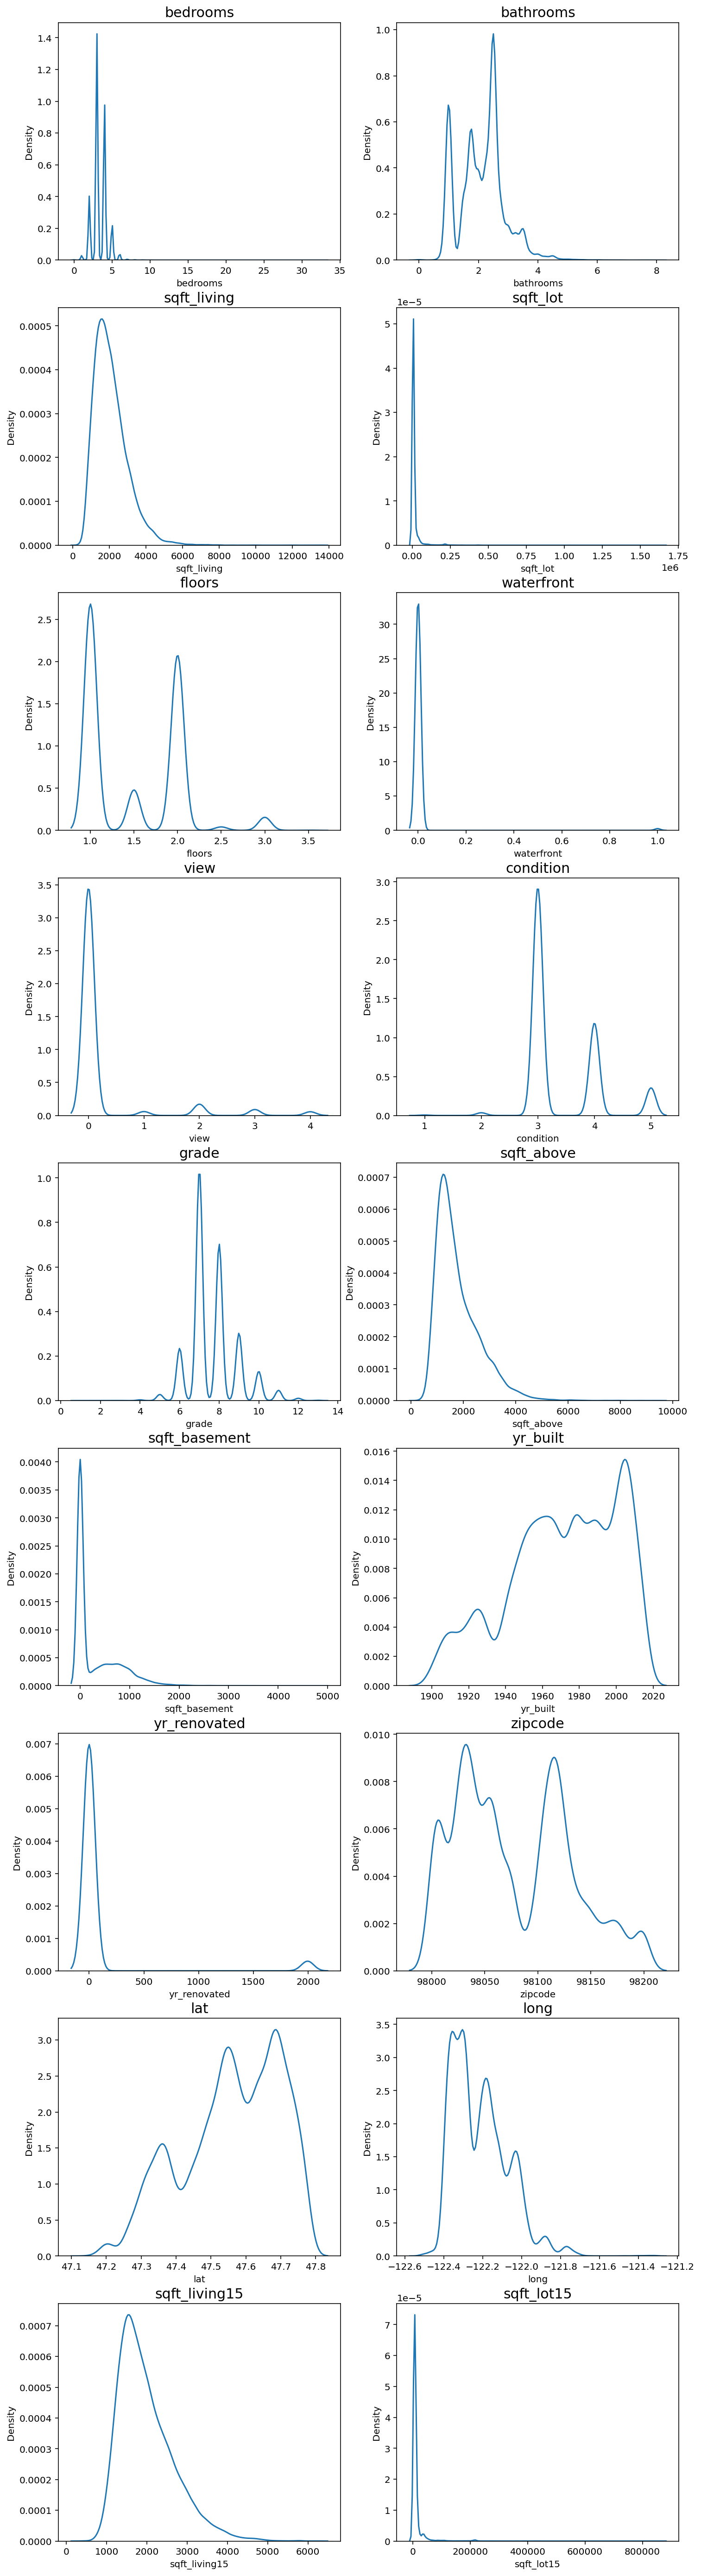

In [12]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보인다

In [13]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


변환이 된 후의 분포 확인

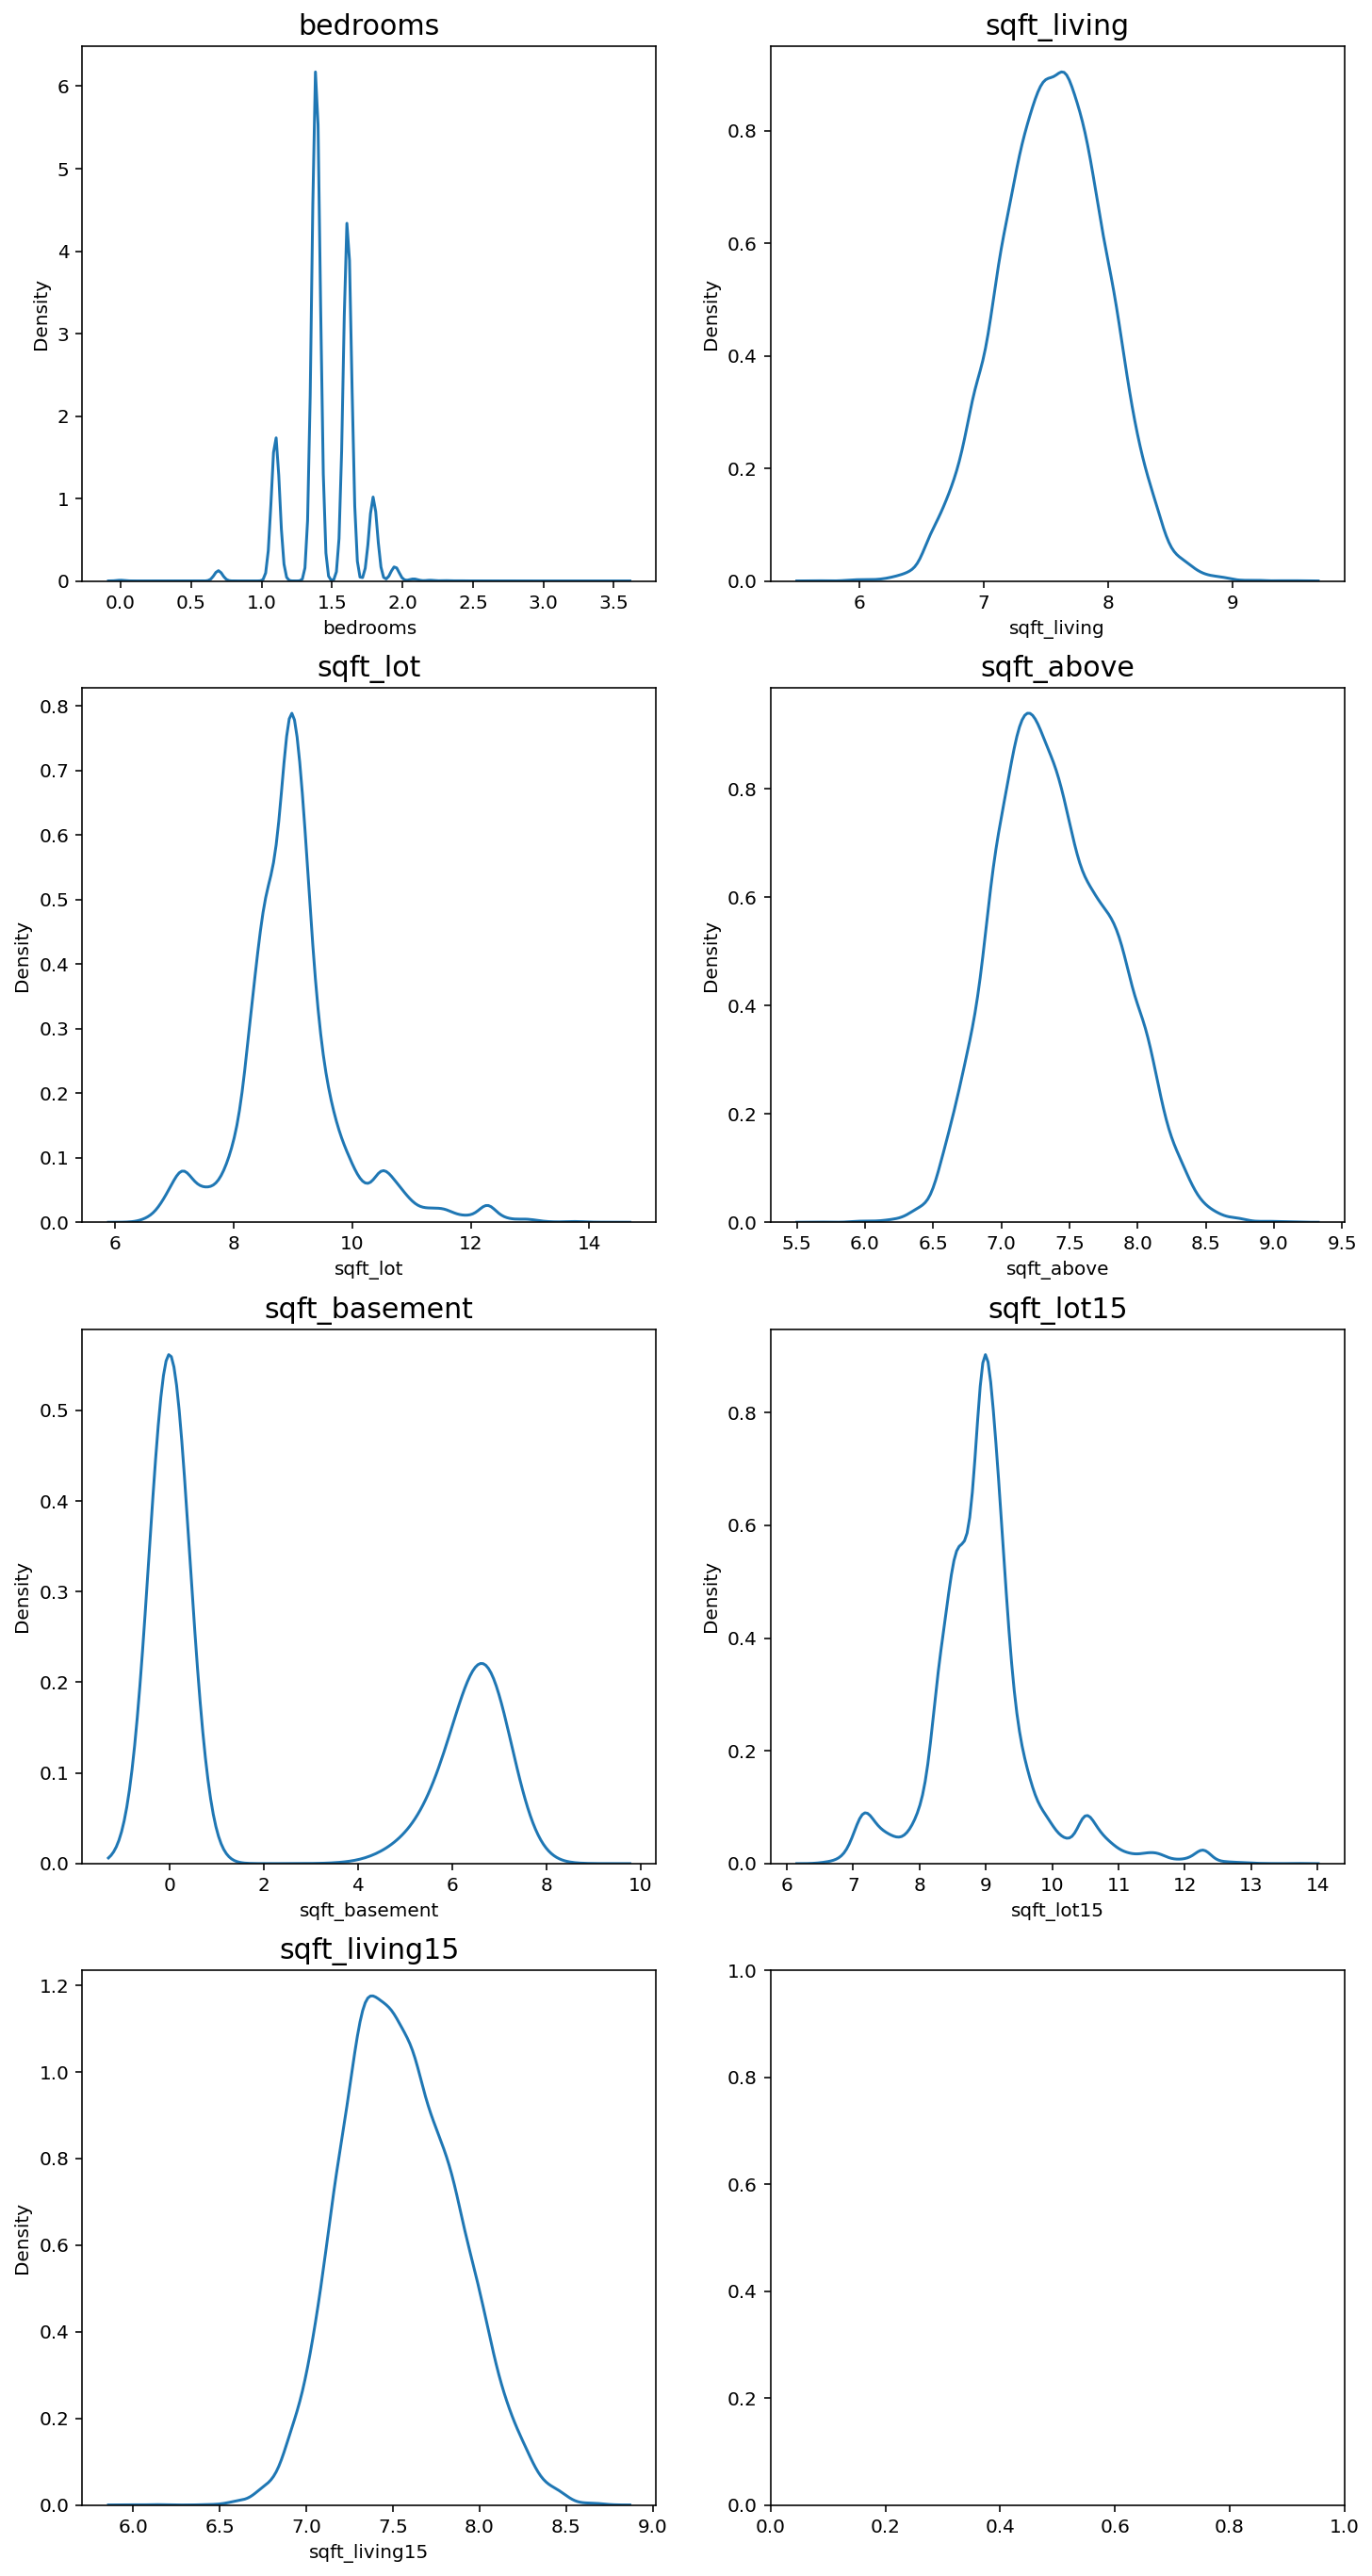

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까?

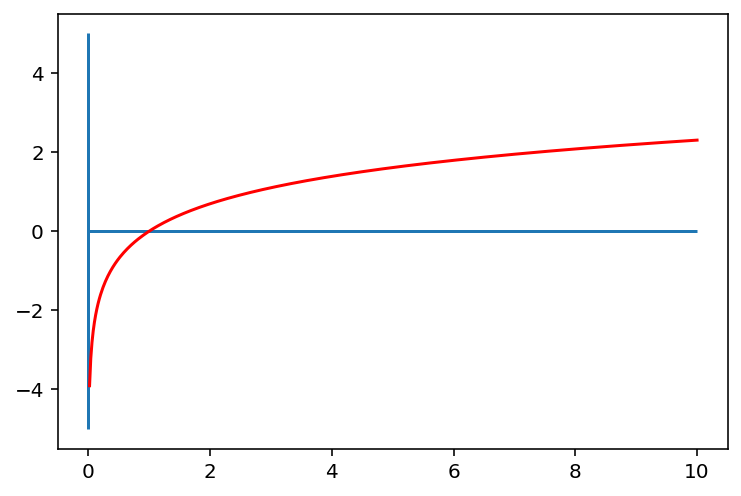

In [15]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

0<x<1 범위에서는 기울기가 매우 가파릅니다. 즉, xx의 구간은 (0, 1)(0,1)로 매우 짧은 반면, yy의 구간은 (-\infty, 0)(−∞,0)으로 매우 큽니다.

따라서 0에 가깝게 모여있는 값들이 xx로 입력되면, 그 함수값인 yy 값들은 매우 큰 범위로 벌어지게 됩니다. 

즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.

반면, xx값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 

이는 곧 큰 xx값들에 대해서는 yy값이 크게 차이나지 않게 된다는 뜻이고, 

따라서 넓은 범위를 가지는 xx를 비교적 작은 yy값의 구간 내에 모이게 하는 특징을 가집니다.

원래 price의 분포

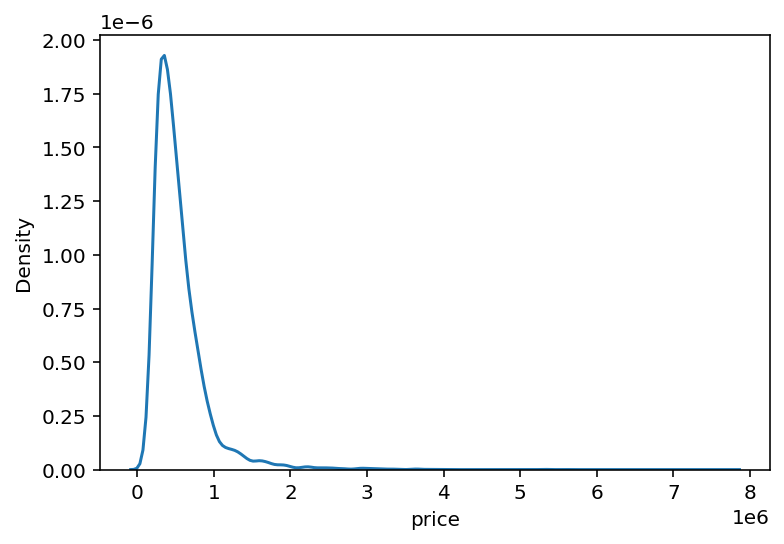

In [16]:
sns.kdeplot(y)
plt.show()

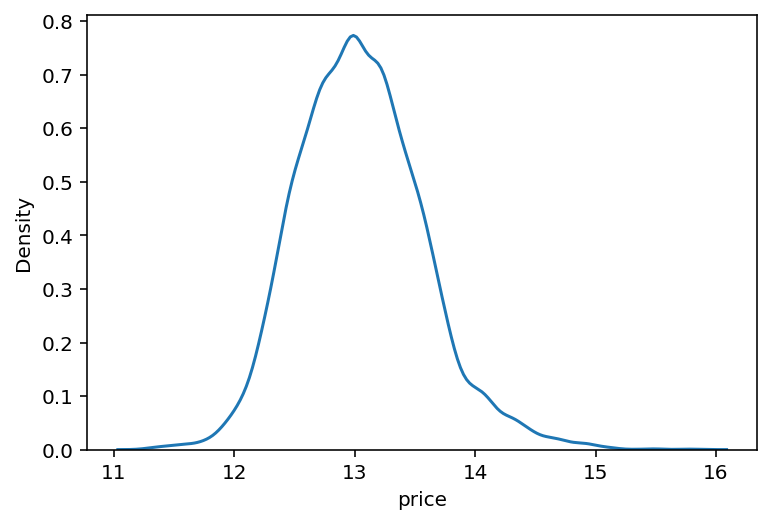

In [17]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

위에서 저장해두었던 train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터, 

즉 x에 저장하고, train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장

In [18]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


Average Blending

In [19]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


Cross Validation

In [20]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))
print('얍💢')

얍💢


In [21]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8598
Model XGBoost CV score : 0.8860
Model LightGBM CV score : 0.8819


ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True. 에러 이유는... 

하이퍼 파라미터 중 random_state를 설정해놓고, shuffle=True 설정을 안 해줘서 그렇다.

랜덤의 여지가 없는데 랜덤하게 하라고 명령한 것이다.

하이퍼 파라미터에 shuffle=True를 넣어준다!

In [22]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))
print('얍💢')

얍💢


In [23]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8598
Model XGBoost CV score : 0.8860
Model LightGBM CV score : 0.8819


Make Submission File

cross_val_score() 함수는 회귀모델을 전달할 경우 R^2R 
2
  점수를 반환합니다.
R^2R 
2
  값은 1에 가까울수록 모델이 잘 학습되었다는 것을 나타냅니다. 

In [24]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


함수를 활용해서 예측값을 생성

In [25]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

제출해야 하는 csv 파일의 샘플이 바로 data 폴더에 있는 sample_submission.csv 파일을 확인

In [26]:
data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/06/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


id와 price로 구성된 데이터 프레임 생성

In [27]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


다음 코드로 submission.csv 파일을 저장

In [28]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/EXPLORATION/06/kaggle_kakr_housing/data/submission.csv


### 최적의 모델을 찾아서, 하이퍼 파라미터 튜닝

다시 한번, 내 입맛대로 데이터 준비하기

In [29]:
data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/06/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


데이터를 다시 한번 살펴보기

In [30]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


Date 값을 int 형으로 

In [31]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


전처리 과정으로 타겟 데이터에 해당하는 price를 변수Y에 넣고 id 칼럼 삭제..

In [32]:
y = train['price']
del train['price']

print(train.columns)

del train['id']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


test 데이터에 대해서도 같은 작업으로 date 값을 int 형으로 바꾸고 id 칼럼 삭제.. 

test 데이터에는

In [33]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


타겟 데이터인 price를 넣은 y값 확인

In [34]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

가격데이터 분포 확인

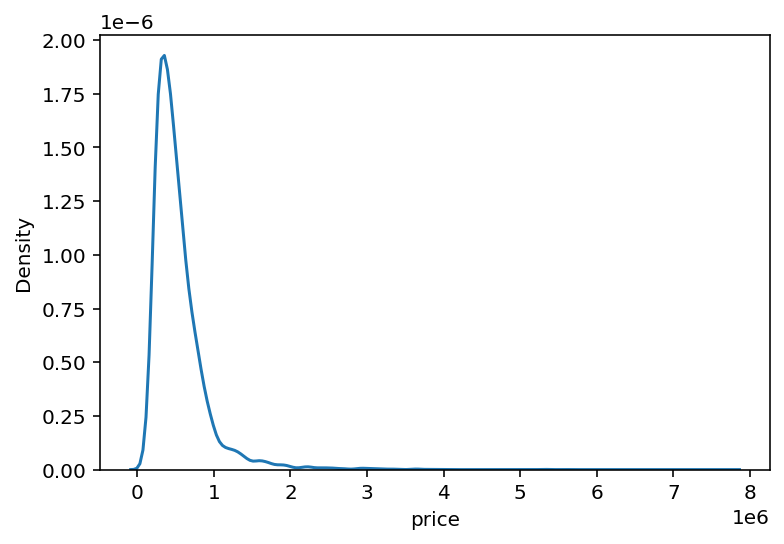

In [35]:
sns.kdeplot(y)
plt.show()

price는 왼쪽으로 크게 치우쳐 있는 형태 이므 y는 np.log1p() 함수를 통해 로그 변환을 해주고, 

나중에 모델이 값을 예측한 후에 다시 np.exp1m()을 활용해서 되돌리기 

np.exp1m()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환하기

In [36]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

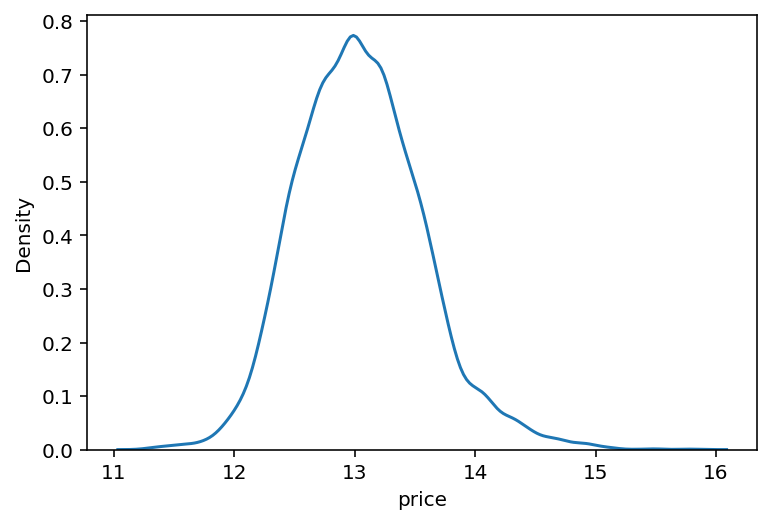

In [37]:
sns.kdeplot(y)
plt.show()

info() 함수로 전체 데이터의 자료형을 한눈에 확인

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## RMSE 계산

라이브러리 가져오기

In [39]:
from sklearn.model_selection import train_test_split #훈련 데이터셋과 검증 데이터셋으로 나누기 위해
from sklearn.metrics import mean_squared_error # RMSE 점수를 계산하기 위해

print('얍💢')

얍💢


mean_squared_error를 계산하기 전에 np.log1p()로 변환이 된 값인 y_test나 y_pred를 

원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1() 사용

mean_squared_error를 계산한 값에 np.sqrt를 이용해서 RMSE 값을 겟....

In [40]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 모델 라이브러리 가져오기


In [41]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


모델 인스턴스를 생성한 후 models라는 리스트에 넣기

베이스라인에서부터 시작해서 다양한 실험을 통해 성능이 개선되는지를 검증하기 위해 

어떤 시도가 모델 성능 향상에 긍정적이었는지 여부를 판단하기 위해.. 랜덤적 요소의 변화 때문에 생기는 불확실성을 제거해야 하므로 

random_state 값을 2020 값으로 고정

In [42]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


각 모델의 이름은 클래스의 __name__ 속성에 접근해서 얻기

In [43]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [44]:
rdforest.__class__.__name__

'RandomForestRegressor'

In [45]:
xgboost.__class__.__name__

'XGBRegressor'

In [46]:
lightgbm.__class__.__name__

'LGBMRegressor'

for문 안에서 각 모델 별로 학습 및 예측

In [47]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

get_scores(models, train, y) 함수로 만들어 실행하기

In [48]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


## 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

파라미터 테스트를 위한 sklearn.model_selection 라이브러리 import 
GridSearchCV 클래스를 활용 테스트

In [49]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


## 그리드 탐색 

먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색

특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리함

## 랜덤 탐색

사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법

랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려 있지만 

그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는것은 아니다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/E10-13.max-800x600.png)

### GridSearchCV에 입력되는 인자

- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

xgboost 관련 하이퍼 파라미터를 param_grid에 넣어서 탐색할 준비

In [50]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

LightGBM(lgbm)모델을 준비

In [51]:
model = LGBMRegressor(random_state=random_state)

print('lgbm 모델준비 완료')

lgbm 모델준비 완료


In [52]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5) #grid_model 을 GridSearchCV로 초기화

grid_model.fit(train, y) #train 과 y 데이터를 이용하여 학습

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.9s finished


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

결과를 grid_model.cv_results_ 안에 저장

In [53]:
grid_model.cv_results_

{'mean_fit_time': array([0.09537435, 0.12573471, 0.24963665, 0.37212796]),
 'std_fit_time': array([0.00198472, 0.0124031 , 0.01052073, 0.00803372]),
 'mean_score_time': array([0.01041055, 0.00815992, 0.01429005, 0.02959914]),
 'std_score_time': array([0.00928918, 0.00025703, 0.00022936, 0.00743289]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [54]:
params = grid_model.cv_results_['params'] #파라미터 조합 
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [55]:
score = grid_model.cv_results_['mean_test_score'] #테스트 점수
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

알아보기 쉽운 형태로 바꿔 출력하기

In [56]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


RMSE 점수를 확인하기 위해 음수로 된 MSE를 -1을 곱해주고 np.sqrt로 루트 연산

In [57]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


RMSLE로 변환

판다스에서 컬럼의 이름 변환은 rename으로 변경

In [58]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [59]:
results = results.sort_values('RMSLE') # RMSLE가 낮은 순서대로 정렬
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


지금까지의 과정을 하나의 함수로 만들어 간결한 코드로 진행

In [60]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""


def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

간결한 코드로 만든 my_GridSearch() 함수 테스트

In [61]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.0s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


가장 좋은 조합은 max_depth=10, n_estimators=100 로 확인되므로

해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출

max_depth=10, n_estimators=100 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성

In [62]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [63]:
prediction = np.expm1(prediction) #np.expm1()을 씌워서 다시 원래 스케일로 되돌리기
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

sample_submission.csv 파일을 가져오기

In [64]:
data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/06/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


데이터 프레임에 우리 모델이 예측한 값을 덮어씌워 제출할 데이터 완성

In [65]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


파일 이름에 모델의 종류와 RMSLE 값을 넣어 생성

In [66]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/EXPLORATION/06/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


지금까지 과정을 하나의 함수로 정리

In [67]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [68]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168') #모델을 학습시킨 후 예측 결과를 저장

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


## This is your playground! Leaderboard를 정복

### 튜닝해볼 수 있는 모델 클래스 인자

대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자

- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력


### 시도해볼 수 있는 방법

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기


### 프로젝트 루브릭

- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

필요한 라이브러리 가져오기

In [69]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import scipy as sp

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

데이터 가져오기

In [70]:
data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/06/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [71]:
print(train)
print(test)

          id             date      price  bedrooms  bathrooms  sqft_living  \
0          0  20141013T000000   221900.0         3       1.00         1180   
1          1  20150225T000000   180000.0         2       1.00          770   
2          2  20150218T000000   510000.0         3       2.00         1680   
3          3  20140627T000000   257500.0         3       2.25         1715   
4          4  20150115T000000   291850.0         3       1.50         1060   
...      ...              ...        ...       ...        ...          ...   
15030  15030  20141014T000000   610685.0         4       2.50         2520   
15031  15031  20150326T000000  1007500.0         4       3.50         3510   
15032  15032  20140521T000000   360000.0         3       2.50         1530   
15033  15033  20150223T000000   400000.0         4       2.50         2310   
15034  15034  20141015T000000   325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_abo

데이터 확인하기...

In [72]:
train.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,...,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,0,...,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,530000.0,5,2.00,1810,4850,1.5,0,0,...,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


In [73]:
test.head(10)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
5,15040,20140703T000000,5,2.50,2270,6300,2.0,0,0,3,8,2270,0,1995,0,98092,47.3266,-122.169,2240,7005
6,15041,20140624T000000,3,1.75,1520,6380,1.0,0,0,3,7,790,730,1948,0,98115,47.6950,-122.304,1520,6235
7,15042,20150302T000000,4,2.50,2570,7173,2.0,0,0,3,8,2570,0,2005,0,98052,47.7073,-122.110,2630,6026
8,15043,20141201T000000,2,1.50,1190,1265,3.0,0,0,3,7,1190,0,2005,0,98133,47.7274,-122.357,1390,1756
9,15044,20140528T000000,4,1.00,1660,34848,1.0,0,0,1,5,930,730,1933,0,98052,47.6621,-122.132,2160,11467


In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [75]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

### Data fields
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [76]:
cols = train.columns
cols

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

결측치 확인

In [77]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

목적변수(price) 정규분포

- np.log1p(y) : 로그함수로 변환
- np.expm1(y) : 각 원소x마다 exp(x)-1을 반환 우선 로그변환을 해준 후 모델이 값을 예측한 후에 다시 np.expm1()을 통해 되돌림

<AxesSubplot:xlabel='price', ylabel='Density'>

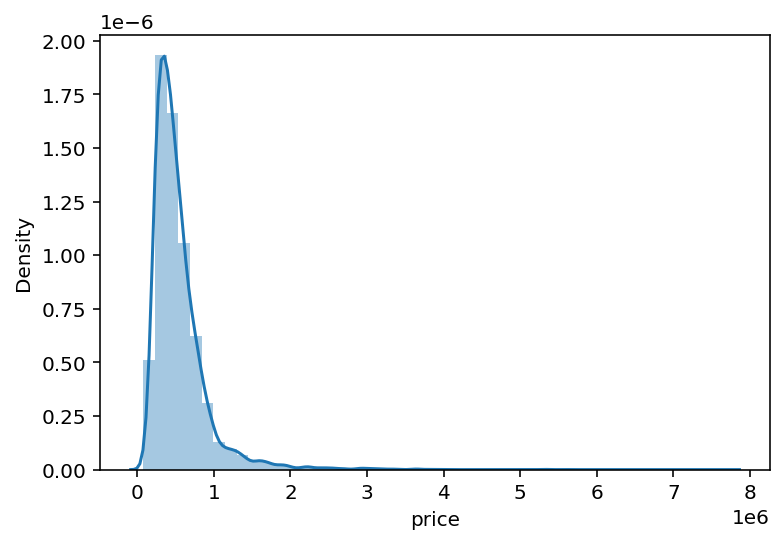

In [78]:
# price 분포 확인
fig, ax = plt.subplots(figsize=(6,4))
sns.distplot(train['price'])

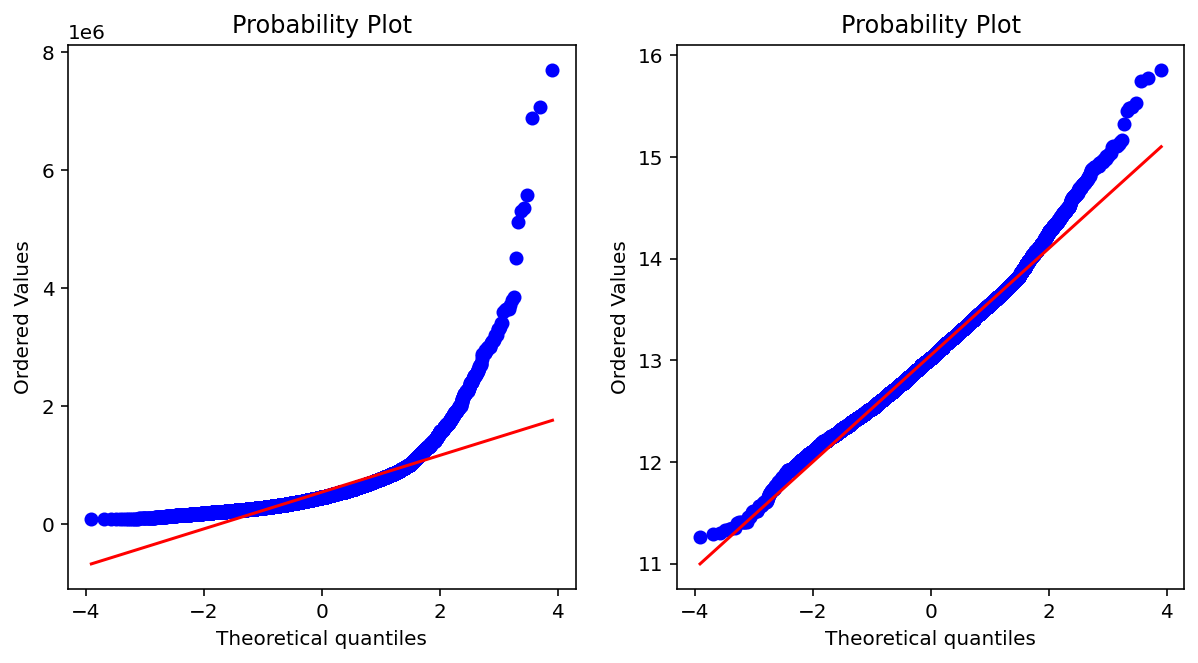

In [79]:
# log를 취해줬을 때 정규성 확인
fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)
res = sp.stats.probplot(train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = sp.stats.probplot(np.log1p(train['price']), plot=plt)

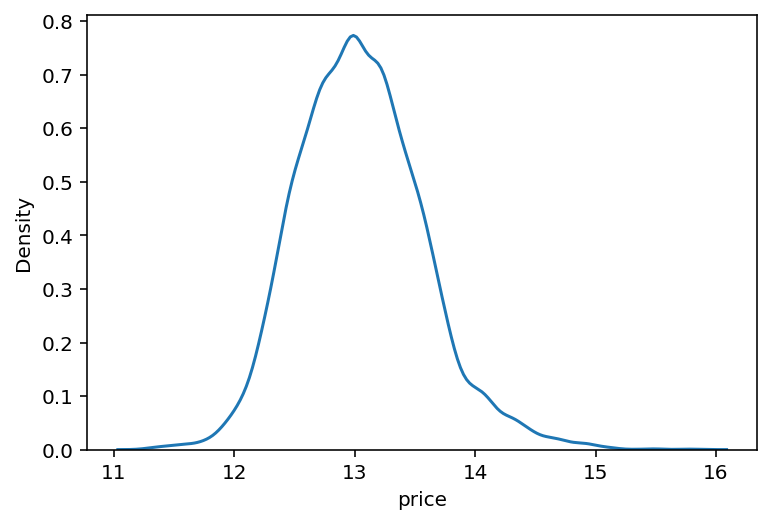

In [80]:
# 목적변수 정규분포
train['price'] = np.log1p(train['price'])
sns.kdeplot(train['price'])
plt.show()



변수시각화(반응변수)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

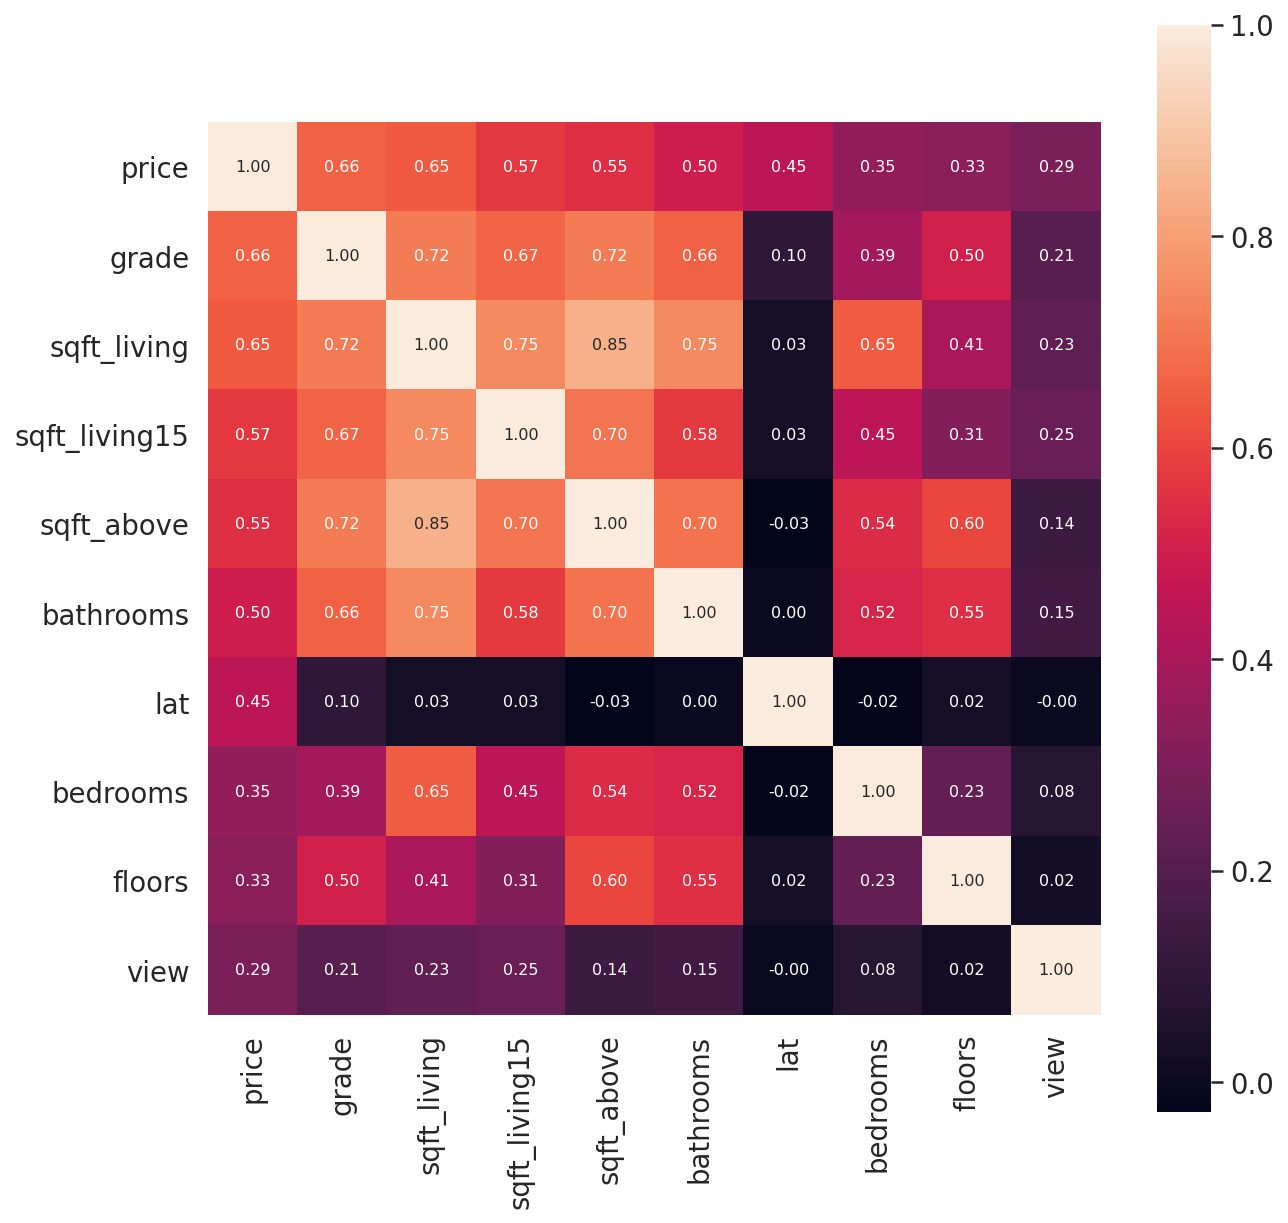

In [81]:
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)


grade 이상치 제거

- grade : King County grading 시스템 기준으로 매긴 집의 등급
- grade가 높을수록 price도 증가하고 있다.
- min과 max를 벗어난 이상치가 확인되고 있다.

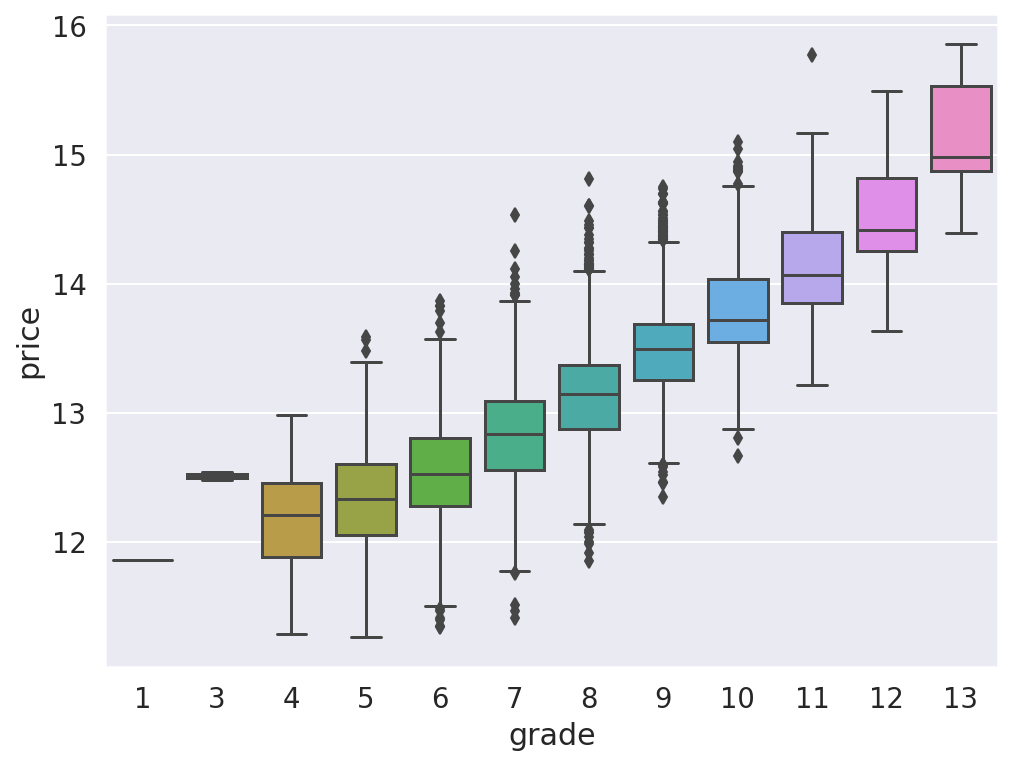

In [82]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data = data)

In [83]:
train.loc[(train['grade'] == 3) & (train['price'] > 12)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [84]:
train.loc[(train['grade'] == 7) & (train['price'] > 14.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [85]:
train.loc[(train['grade'] == 8) & (train['price'] > 14.7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [86]:
train.loc[(train['grade'] == 11) & (train['price'] > 15.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [87]:
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 12346]
train = train.loc[train['id'] != 7173]
train = train.loc[train['id'] != 2775]
print(len(train['id']))

15030


sqft_living 이상치 제거

- sqft_living : 주거 공간의 평방 피트(면적)
- 전체적으로 크기가 커지면 가격이 오르는 것을 볼 수 있다.
- 하지만 14000일때 가격이 비교적 아래에 있는 것을 보아 이상치로 확인된다

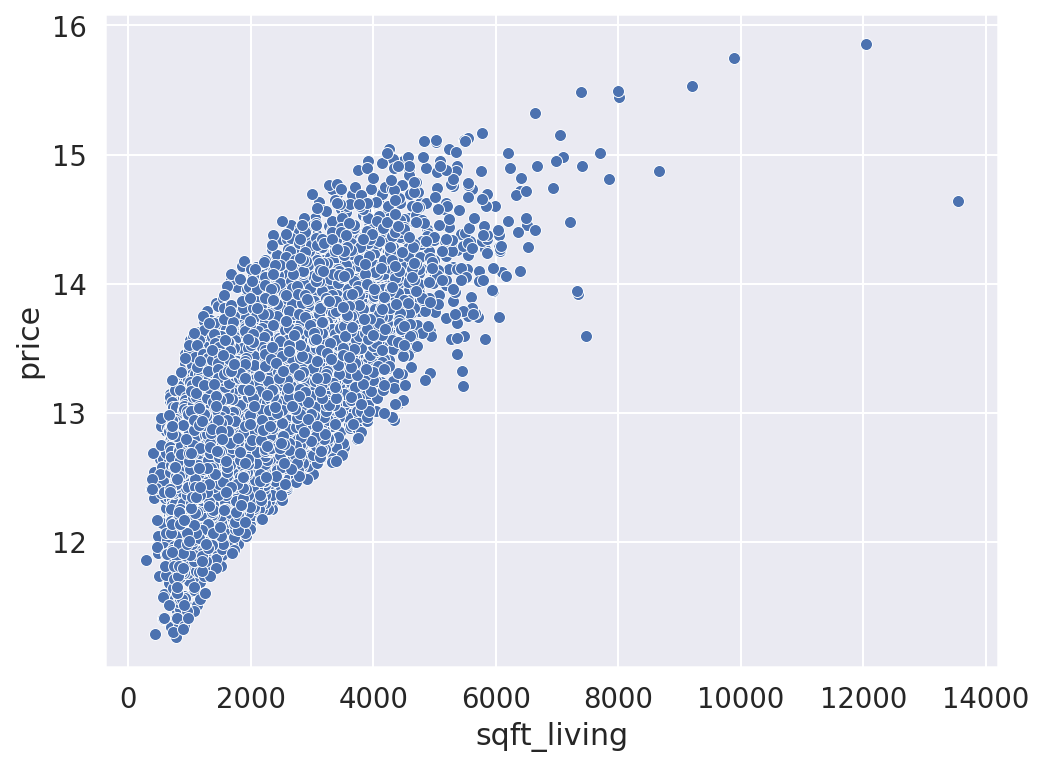

In [88]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='sqft_living', y='price', data = data)

In [89]:
train.loc[train['sqft_living']>13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [90]:
train = train.loc[train['id'] != 8912]
print(len(train['id']))

15029


sqft_above

sqft_above : 지하실을 제외한 평방 피트(면적)

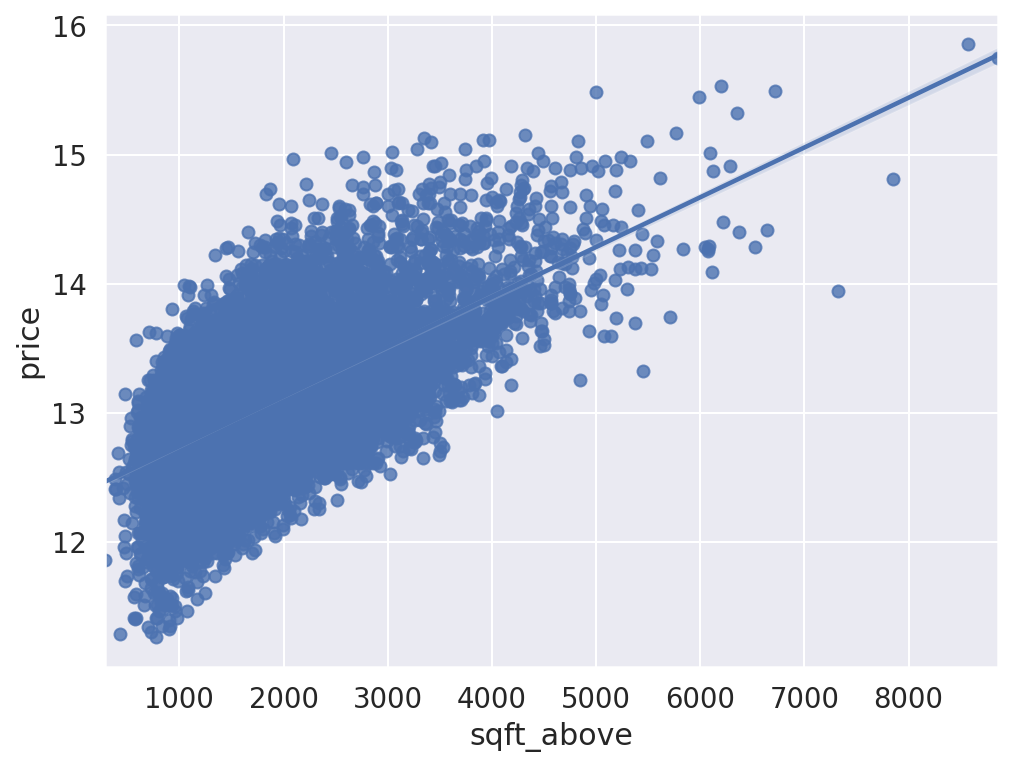

In [91]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y='price', data = data)

bathrooms

- bathrooms : 화장실의 수
- 0.5 : 세면대, 화장실
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조

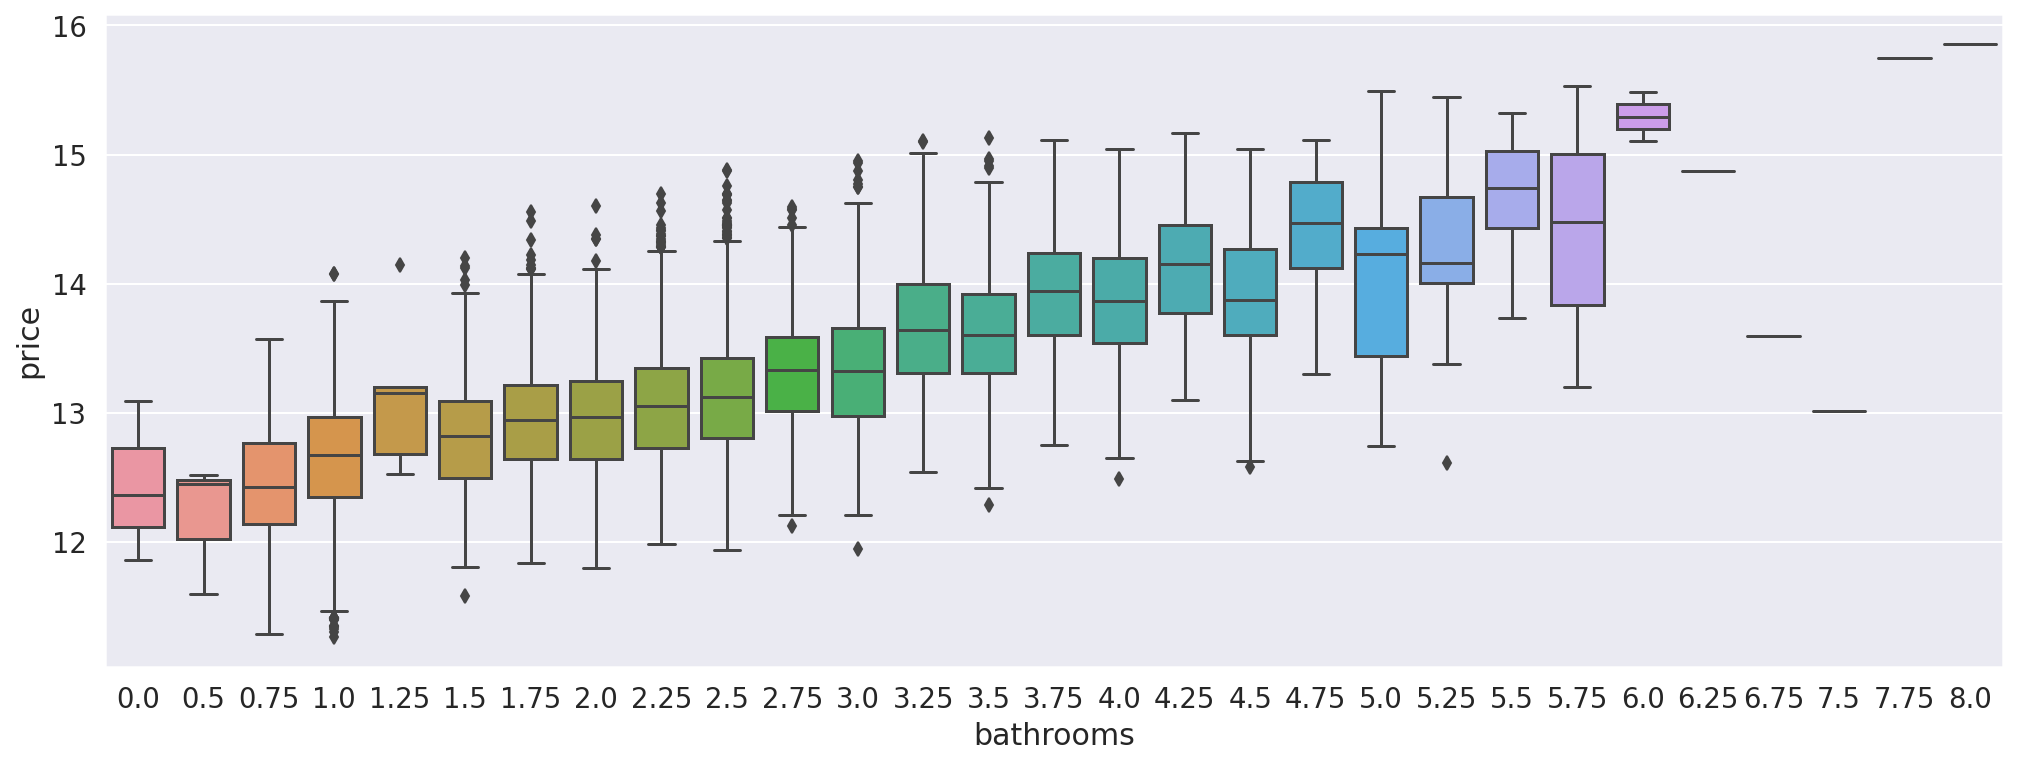

In [92]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(17, 6))
fig = sns.boxplot(x='bathrooms', y='price', data = data)

lat 위도

위도 47.5 ~ 47.8에 위치하는 집이 가격이 높은 것을 볼 수 있다.

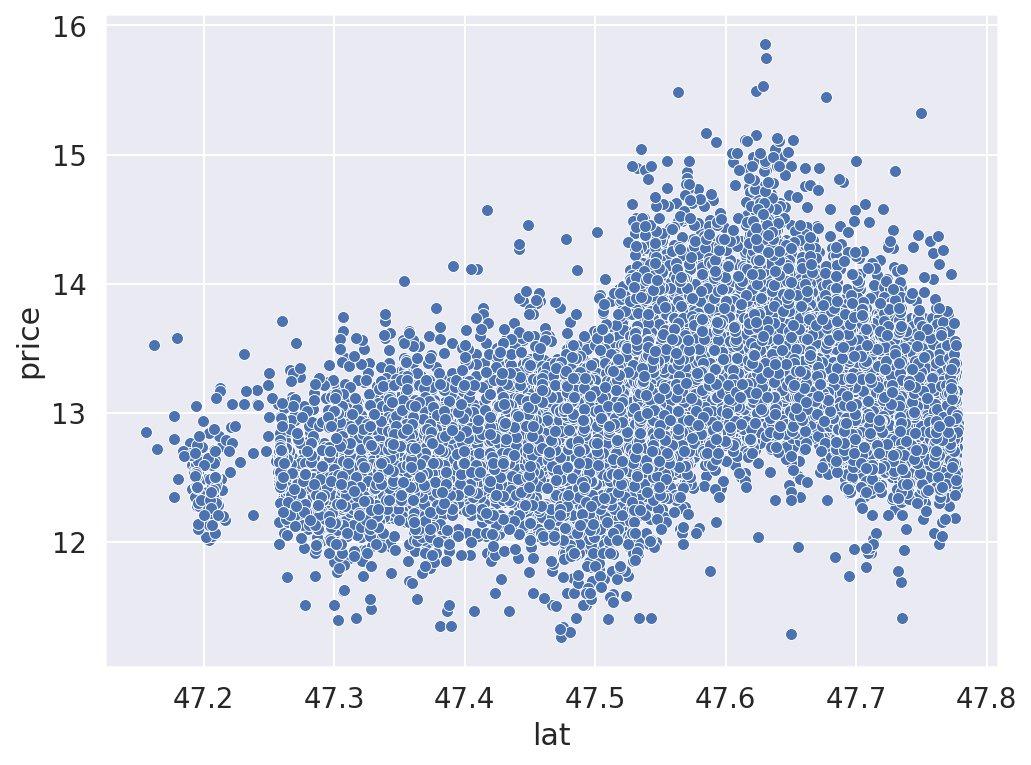

In [93]:
data = pd.concat([train['price'], train['lat']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='lat', y='price', data = data)

date 형태 변환

before : 20141013T000000

after : 201410

In [94]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

floors, waterfront, condition

In [95]:
print(train['waterfront'].unique())
print(train['view'].unique())
print(train['condition'].unique())

[0 1]
[0 3 4 2 1]
[3 4 5 2 1]


id 삭제

In [96]:
del train['id'] 
del test['id'] #id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거

정규화

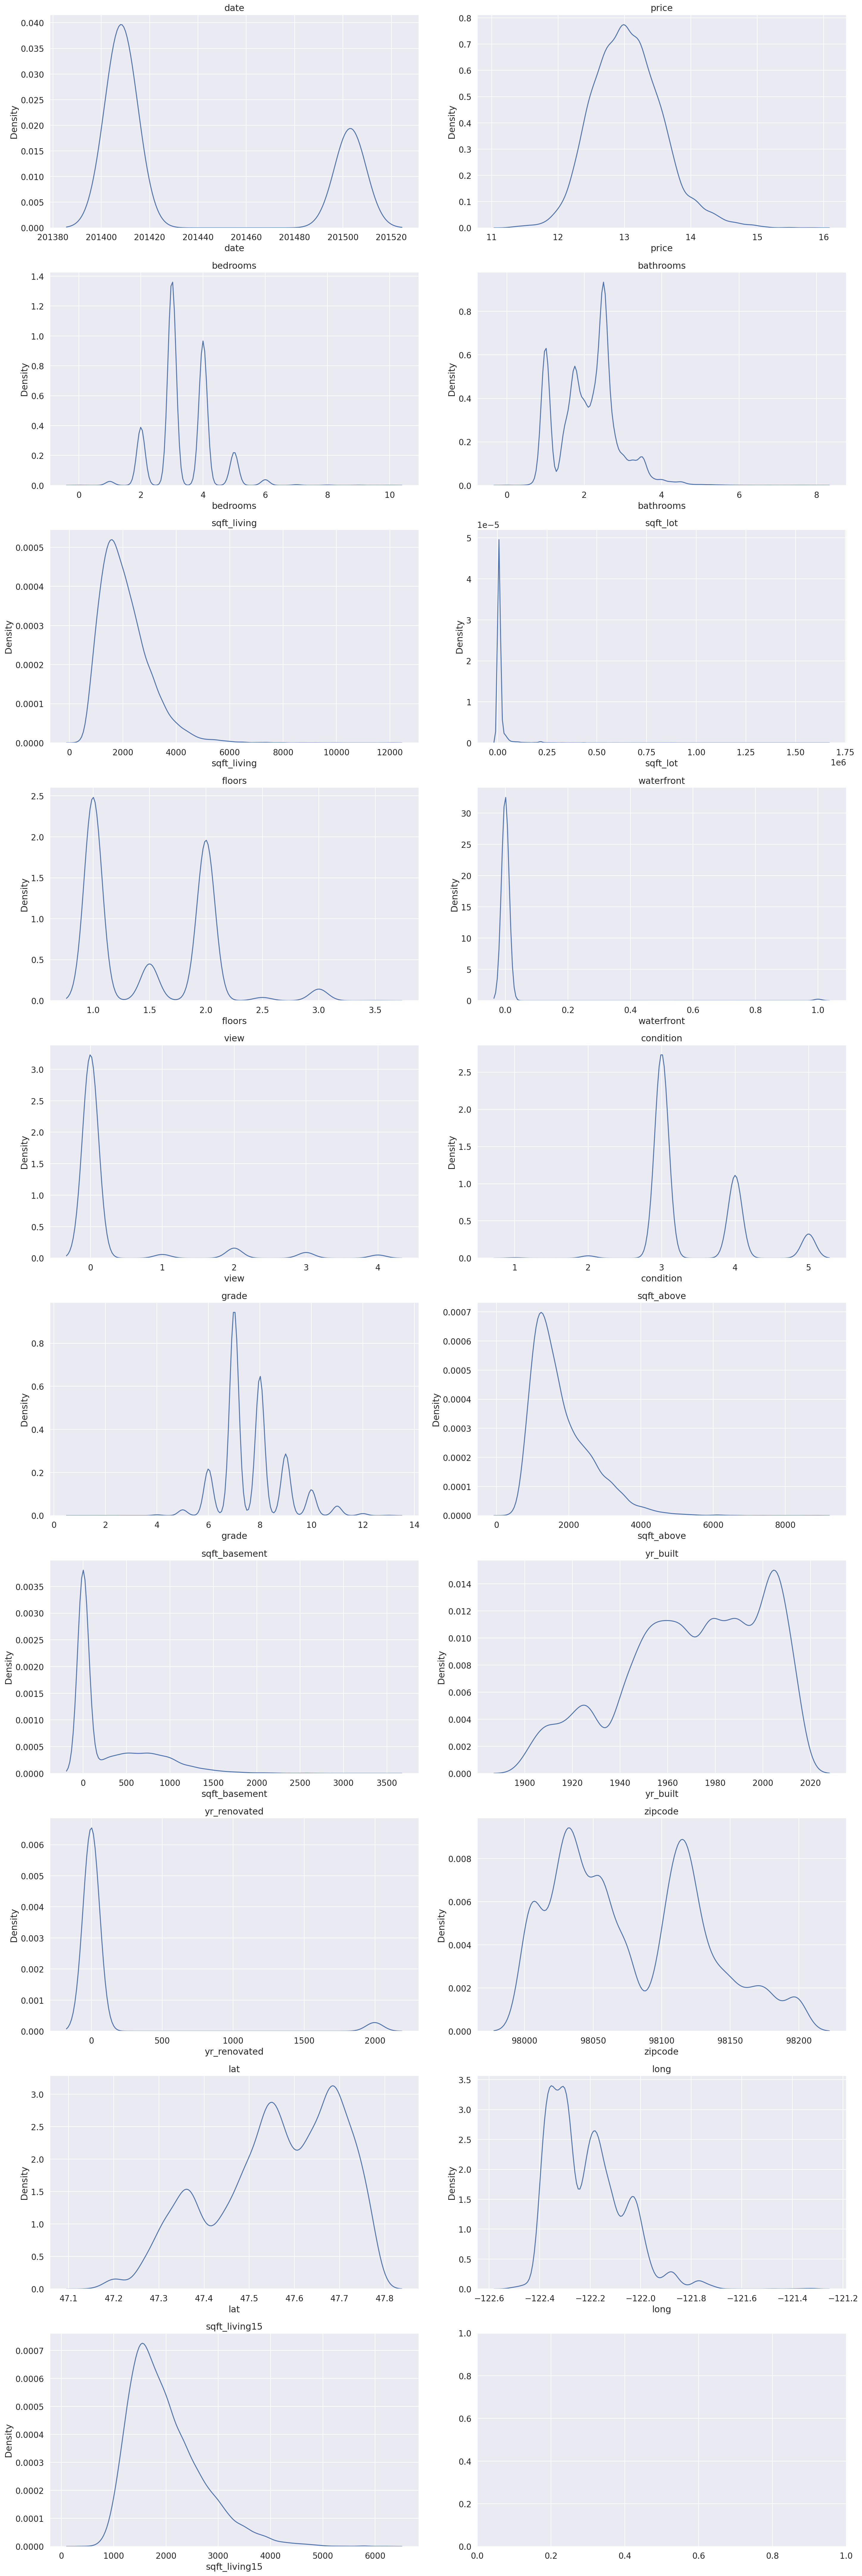

In [97]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60), constrained_layout=True)
columns = train.columns
count = 0
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

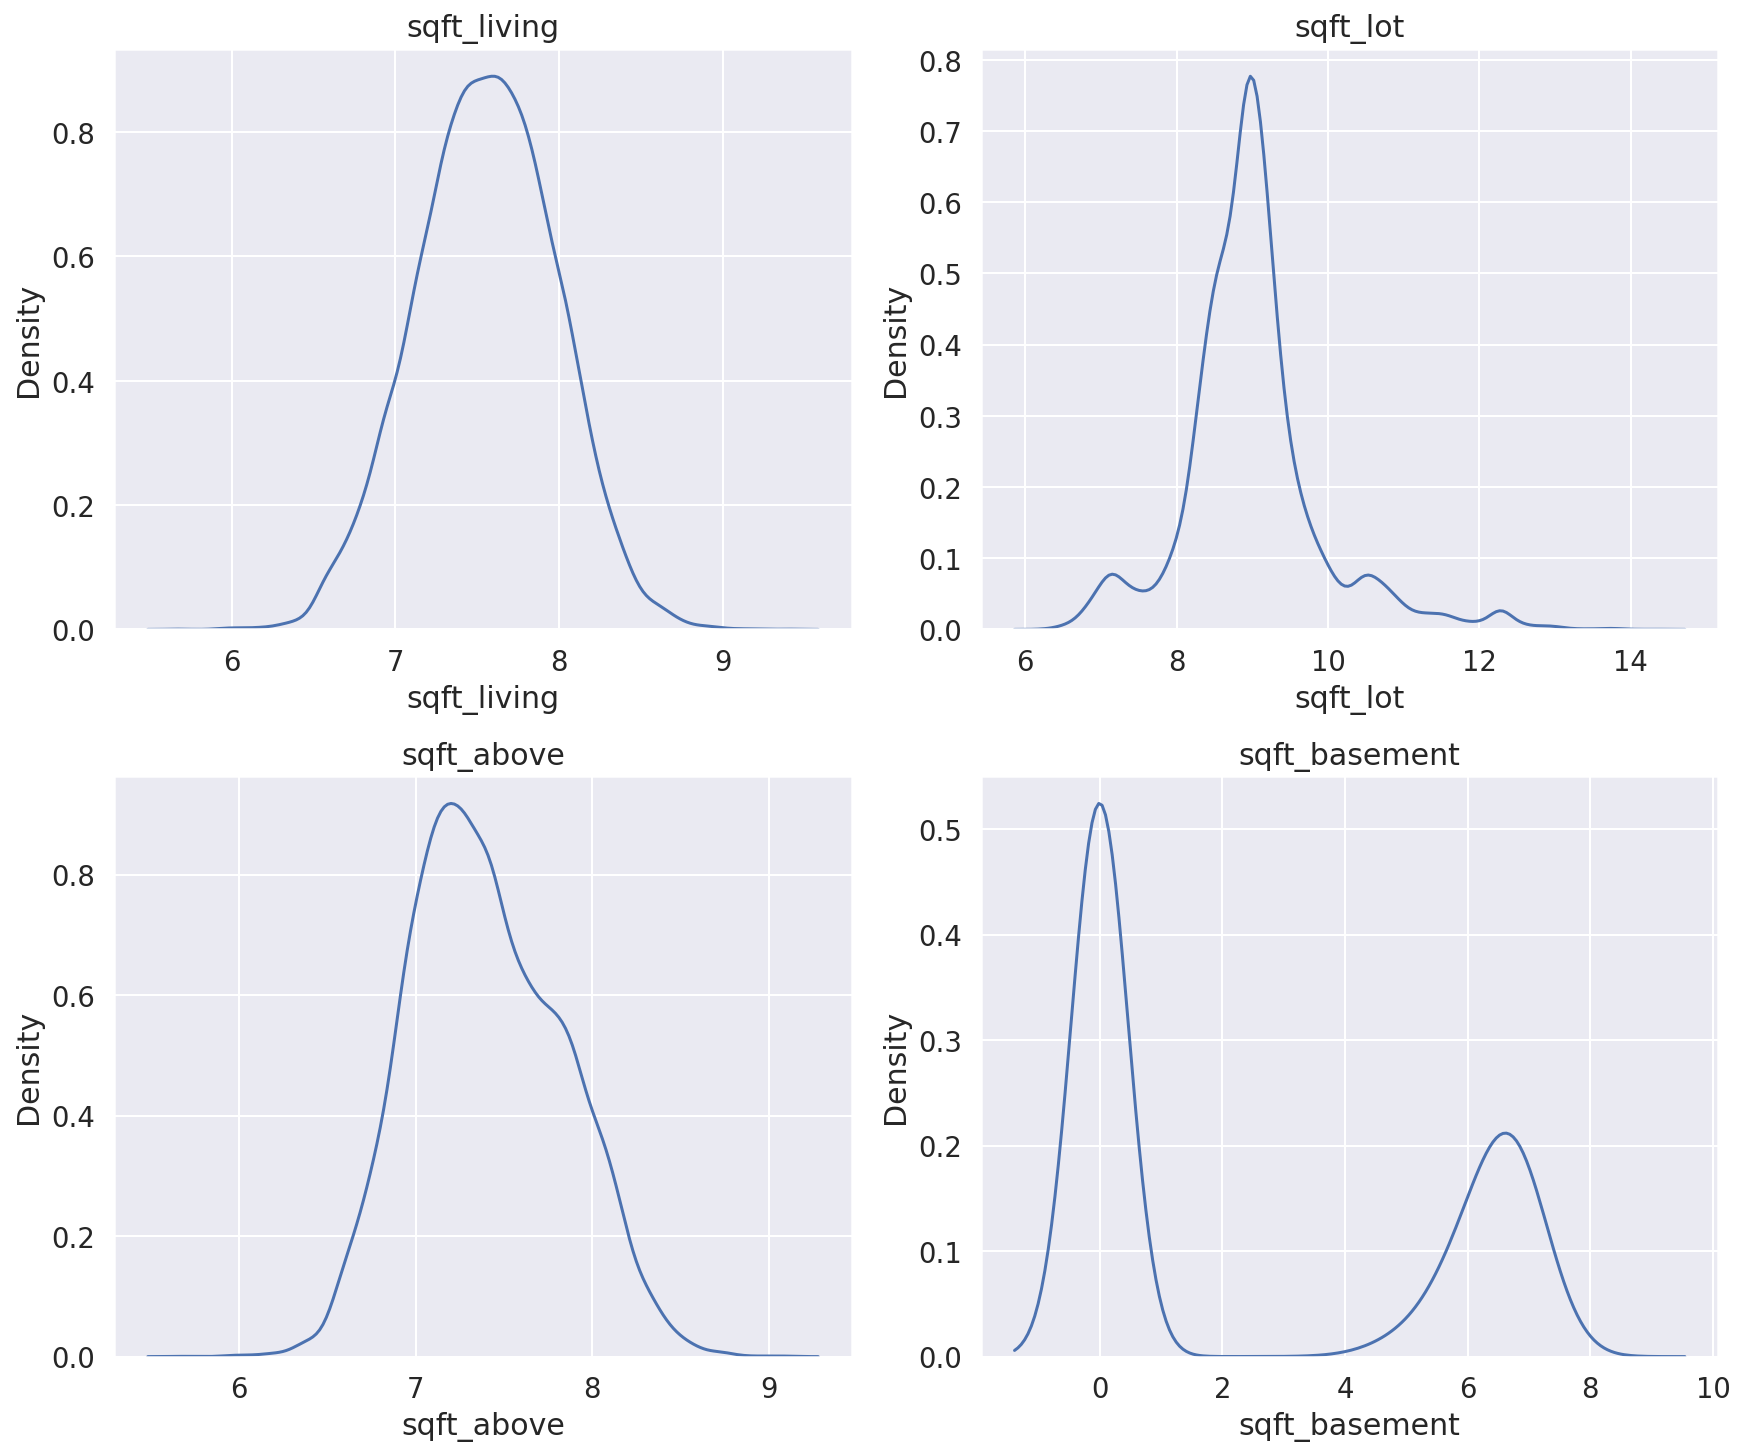

In [98]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

fig, ax = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

count = 0
for row in range(2):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

타겟 데이터인 price컬럼 분리

In [99]:
y = train['price']
del train['price']

자료형 확인

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15029 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15029 non-null  int64  
 1   bedrooms       15029 non-null  int64  
 2   bathrooms      15029 non-null  float64
 3   sqft_living    15029 non-null  float64
 4   sqft_lot       15029 non-null  float64
 5   floors         15029 non-null  float64
 6   waterfront     15029 non-null  int64  
 7   view           15029 non-null  int64  
 8   condition      15029 non-null  int64  
 9   grade          15029 non-null  int64  
 10  sqft_above     15029 non-null  float64
 11  sqft_basement  15029 non-null  float64
 12  yr_built       15029 non-null  int64  
 13  yr_renovated   15029 non-null  int64  
 14  zipcode        15029 non-null  int64  
 15  lat            15029 non-null  float64
 16  long           15029 non-null  float64
 17  sqft_living15  15029 non-null  int64  
 18  sqft_l

### RMSE

기존에 y를 로그함수로 변환해주었기 때문에 mean_squared_error에 값을 넘기기 전,
np.expm1으로 다시 변환해서 넘겨준다.

In [102]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 모델별 학습 및 예측

In [103]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리 - 여기에도 random_state를 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        # 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        # 예측결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df


In [104]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,148717.815398
RandomForestRegressor,128899.575906
XGBRegressor,119790.798524
LGBMRegressor,117430.851668


### 하이퍼파라미터 탐색

그리드 탐색

GridSearchCV 사용 (Grid Search)

- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [105]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              verbose=verbose,
                              n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']          # 각 파라미터에 대한 조합
    score = grid_model.cv_results_['mean_test_score']  # 각 조합에 대한 점수

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])  # rmse: 평균제곱근오차
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results = results.sort_values('RMSLE')  # `RMSLE`가 낮은 순서대로 정렬

    return results

- 각 파라미터에 대한 조합마다의 점수를 나타냄
- 왜 음수일까?
    
    scoring : 'neg_mean_squared_error'
    
    neg_mean_squared_error : 평균 제곱 오차의 반댓값(음수)을 계산
    
    점수가 올라가면 좋다! (즉, 돈을 적게 잃어야 하는 것과 같다)

In [106]:
# LGBMRegressor
param_grid = {
    "n_estimators":[50, 100, 500],
    "max_depth":[1, 6, 10],
    "learning_rate": [0.05, 0.1],
    "boosting_type": ['gbdt', 'rf', 'dart', 'goss']
}

lgbmr_model = LGBMRegressor(random_state=random_state)

my_GridSearch(lgbmr_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 225 tasks      | elapsed:   33.8s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:  1.5min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSLE
8,gbdt,0.05,10,500,-0.025783,0.160571
62,goss,0.05,10,500,-0.025877,0.160863
5,gbdt,0.05,6,500,-0.026071,0.161465
59,goss,0.05,6,500,-0.026094,0.161537
17,gbdt,0.10,10,500,-0.026123,0.161626
...,...,...,...,...,...,...
31,rf,0.10,6,100,NaN,NaN
32,rf,0.10,6,500,NaN,NaN
33,rf,0.10,10,50,NaN,NaN
34,rf,0.10,10,100,NaN,NaN


In [109]:
# XGBRegressor
param_grid = {
    "n_estimators":[50, 100, 500],
    "max_depth":[1, 6, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "booster": ['gblinear', 'gbtree', 'dart']
}

xgbr_model = XGBRegressor(random_state=random_state)

my_GridSearch(xgbr_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 10.6min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 118.6min
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed: 282.8min finished


,booster,learning_rate,max_depth,n_estimators,score,RMSLE
86,dart,0.05,6,500,-0.026033,0.161346
50,gbtree,0.05,6,500,-0.026047,0.161390
59,gbtree,0.10,6,500,-0.026102,0.161561
95,dart,0.10,6,500,-0.026184,0.161814
53,gbtree,0.05,10,500,-0.026369,0.162386
...,...,...,...,...,...,...
42,gbtree,0.01,10,50,-57.809971,7.603287
78,dart,0.01,10,50,-57.810474,7.603320
75,dart,0.01,6,50,-57.810474,7.603320
36,gbtree,0.01,1,50,-57.847623,7.605763


In [108]:
# RandomForestRegressor
param_grid = {
    "n_estimators":[50, 100, 500],
    "max_depth":[1, 6, 10, None]
}

rf_model = RandomForestRegressor(random_state=random_state)

my_GridSearch(rf_model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   37.1s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:  2.6min finished


,max_depth,n_estimators,score,RMSLE
11,NaN,500,-0.031344,0.177041
10,NaN,100,-0.031535,0.177581
9,NaN,50,-0.031848,0.178459
8,10.0,500,-0.034776,0.186484
7,10.0,100,-0.034846,0.186672
6,10.0,50,-0.035065,0.187256
4,6.0,100,-0.050326,0.224334
5,6.0,500,-0.050404,0.224508
3,6.0,50,-0.050527,0.224783
0,1.0,50,-0.177182,0.420930


LGBMRegressor : 위에서 max_depth = 10, n_estimators=100이 가장 좋은 조합으로 나왔다.

XGBRegressor : max_depth=10, nestimators=50

## csv에 쓰기

In [114]:
def save_submission(model, train, y, test, model_name, rmsle):
    # 위에 나온 결과로 학습 및 예측 결과 생성
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/06/kaggle_kakr_housing/data'
    
    # csv에 쓰기
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))


In [115]:
# LGBMRegressor
lgbmr_model = LGBMRegressor(max_depth=10, n_estimators=500, random_state=random_state)
save_submission(lgbmr_model, train, y, test, 'lgbm', rmsle='0.161020')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/EXPLORATION/06/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161020.csv saved!


In [116]:
# XGBRegressor
xgbr_model = XGBRegressor(max_depth=6, n_estimators=500, learning_rate=0.05, booster='dart', random_state=random_state)
save_submission(xgbr_model, train, y, test, 'xgb', rmsle='0.160962')

/aiffel/aiffel/EXPLORATION/06/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.160962.csv saved!


In [117]:
# RandomForestRegressor
rf_model = RandomForestRegressor(max_depth=None, n_estimators=500, random_state=random_state)
save_submission(rf_model, train, y, test, 'rf', rmsle='0.177373')

/aiffel/aiffel/EXPLORATION/06/kaggle_kakr_housing/data/submission_rf_RMSLE_0.177373.csv saved!


## 회고

해커톤 이전에 해커톤을 대비한 케글 체험이라는 의미로 준비된 EXPLORATION 이기에 최대한 이해하고 넘어가려고 시간을 많이 투자햇던 노드였다.

다행히 해커톤까지 무사히 마칠수 있었지만... 어찌보면 처음 느꼈던 모델링에 대한 결과값을 얻는데 많은 시간이 걸린다는것을 경험할수 있엇던 노드였던것 같다.

전처리 과정과 적합한 최상의 모델링을 선택하여 결과값을 예측하고 모델을 돌려 결과를 얻기까지 잘못된 선택을 하게되면.. 

결과를 얻기까지 아무것도 할수 없이 가만히 지켜만 봐야 하는 시간이 살짝 답답함이 느껴졌다.